In [1]:
import os
import sys
sys.path.append('/kaggle/input/timm-0-6-9/pytorch-image-models-master')
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
from tqdm import tqdm
import time
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

In [2]:
CFG = {
    'seed': 42,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 100, 
    'valid_bs': 64,
    'lr': 1e-3, 
    'weight_decay': 1e-6,
    'num_workers': 2
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

labels = expand_contact_id(pd.read_csv("/kaggle/input/nfl-player-contact-detection/sample_submission.csv"))

test_tracking = pd.read_csv("/kaggle/input/nfl-player-contact-detection/test_player_tracking.csv")

test_helmets = pd.read_csv("/kaggle/input/nfl-player-contact-detection/test_baseline_helmets.csv")

test_video_metadata = pd.read_csv("/kaggle/input/nfl-player-contact-detection/test_video_metadata.csv")

In [5]:
!mkdir -p ../work/frames

for video in tqdm(test_helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i /kaggle/input/nfl-player-contact-detection/test/{video} -q:v 2 -f image2 /kaggle/work/frames/{video}_%04d.jpg -hide_banner -loglevel error

100%|██████████| 4/4 [00:45<00:00, 11.41s/it]


In [6]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

test, feature_cols = create_features(labels, test_tracking, use_cols=use_cols)
test

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug
0,58168_003392_0_37084_37211,0,58168_003392,0,37084,37211,41.90,20.08,0.54,0.06,...,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,3.794232,False
1,58168_003392_0_37084_38556,0,58168_003392,0,37084,38556,41.90,20.08,0.54,0.06,...,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,10.530043,False
2,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False
3,58168_003392_0_37084_38590,0,58168_003392,0,37084,38590,41.90,20.08,0.54,0.06,...,40.33,25.28,0.52,0.06,141.08,100.37,0.59,0.58,5.431841,False
4,58168_003392_0_37084_39947,0,58168_003392,0,37084,39947,41.90,20.08,0.54,0.06,...,40.11,26.73,0.99,0.09,163.38,90.69,1.68,1.64,6.886697,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49583,58172_003247_125_52521_52939,0,58172_003247,125,52521,52939,23.44,4.04,1.41,0.15,...,37.94,2.10,2.29,0.24,211.73,215.11,2.43,-2.43,14.629204,False
49584,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
49585,58172_003247_125_52852_52939,0,58172_003247,125,52852,52939,32.67,2.18,2.34,0.24,...,37.94,2.10,2.29,0.24,211.73,215.11,2.43,-2.43,5.270607,False
49586,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [7]:
test_filtered = test.query('not distance>2').reset_index(drop=True)
test_filtered['frame'] = (test_filtered['step']/10*59.94+5*59.94).astype('int')+1
test_filtered

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame
0,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False,300
1,58168_003392_0_37084_G,0,58168_003392,0,37084,G,41.90,20.08,0.54,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
2,58168_003392_0_37211_46445,0,58168_003392,0,37211,46445,39.59,17.07,0.53,0.05,...,18.08,1.10,0.10,148.93,92.39,2.03,2.03,1.258014,False,300
3,58168_003392_0_37211_G,0,58168_003392,0,37211,G,39.59,17.07,0.53,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
4,58168_003392_0_38556_G,0,58168_003392,0,38556,G,41.93,30.61,0.67,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,58172_003247_125_48241_G,0,58172_003247,125,48241,G,33.86,-1.28,0.79,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6627,58172_003247_125_48335_G,0,58172_003247,125,48335,G,44.74,3.16,4.72,0.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6628,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6629,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049


In [8]:
del test, labels, test_tracking
gc.collect()

53

In [9]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [10]:
video2helmets = {}
test_helmets_new = test_helmets.set_index('video')
for video in tqdm(test_helmets.video.unique()):
    video2helmets[video] = test_helmets_new.loc[video].reset_index(drop=True)
    
del test_helmets, test_helmets_new
gc.collect()

100%|██████████| 4/4 [00:00<00:00, 178.04it/s]


21

In [11]:
video2frames = {}

for game_play in tqdm(test_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f'/kaggle/work/frames/{video}*'))))

100%|██████████| 2/2 [00:00<00:00, 51.83it/s]


In [12]:
class MyDataset(Dataset):
    def __init__(self, df, aug=valid_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    # @lru_cache(1024)
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
   
    def __getitem__(self, idx):   
        window = 24
        frame = self.frame[idx]
        
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)

        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        for view in ['Endzone', 'Sideline']:
            video = self.game_play[idx] + f'_{view}.mp4'

            tmp = video2helmets[video]
#             tmp = tmp.query('@frame-@window<=frame<=@frame+@window')
            tmp[tmp['frame'].between(frame-window, frame+window)]
            tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
            tmp_frames = tmp.frame.values
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
#0.002s

            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    bboxes.append([x, w, y, h])
                else:
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            bboxes = bboxes[::4]

            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0
#0.03s
                    
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and f <= video2frames[video]:
                    img = cv2.imread(f'/kaggle/work/frames/{video}_{f:04d}.jpg', 0)

                    x, w, y, h = bboxes[i]

                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    img_new[:img.shape[0], :img.shape[1]] = img
                    
                imgs.append(img_new)
#0.06s
                
        feature = np.float32(self.feature[idx])

        img = np.array(imgs).transpose(1, 2, 0)    
        img = self.aug(image=img)["image"]
        label = np.float32(self.df.contact.values[idx])

        return img, feature, label

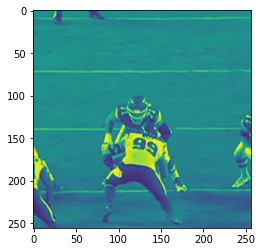

(torch.Size([26, 256, 256]),
 array([4.1900002e+01, 2.0080000e+01, 5.4000002e-01, 5.9999999e-02,
        2.5269000e+02, 2.6231000e+02, 9.2000002e-01, 8.9999998e-01,
        4.0369999e+01, 1.9879999e+01, 6.6000003e-01, 7.0000000e-02,
        1.3670000e+02, 8.8919998e+01, 8.9999998e-01, 8.8999999e-01,
        1.5430166e+00, 0.0000000e+00], dtype=float32),
 0.0)

In [13]:
img, feature, label = MyDataset(test_filtered, valid_aug, 'test')[0]
plt.imshow(img.permute(1,2,0)[:,:,7])
plt.show()
img.shape, feature, label

In [14]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG['model'], pretrained=False, num_classes=500, in_chans=13)
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # nn.Linear(64, 64),
            # nn.LayerNorm(64),
            # nn.ReLU(),
            # nn.Dropout(0.2)
        )
        self.fc = nn.Linear(64+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y

In [15]:
test_set = MyDataset(test_filtered, valid_aug, 'test')
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], shuffle=False, num_workers=CFG['num_workers'], pin_memory=True)

model = Model().to(device)
model.load_state_dict(torch.load('/kaggle/input/nfl-exp1/resnet50_fold0.pt'))

model.eval()
    
y_pred = []
with torch.no_grad():
    tk = tqdm(test_loader, total=len(test_loader))
    for step, batch in enumerate(tk):
        if(step % 4 != 3):
            img, feature, label = [x.to(device) for x in batch]
            output1 = model(img, feature).squeeze(-1)
            output2 = model(img.flip(-1), feature).squeeze(-1)
            
            y_pred.extend(0.15*(output1.sigmoid().cpu().numpy()) + 0.85*(output2.sigmoid().cpu().numpy()))
        else:
            img, feature, label = [x.to(device) for x in batch]
            output = model(img.flip(-1), feature).squeeze(-1)
            y_pred.extend(output.sigmoid().cpu().numpy())    

y_pred = np.array(y_pred)

100%|██████████| 104/104 [17:00<00:00,  9.82s/it]


In [16]:
test_filtered['contact'] = y_pred

sub = pd.read_csv('/kaggle/input/nfl-player-contact-detection/sample_submission.csv')

sub = sub.drop("contact", axis=1).merge(test_filtered[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0)#.astype('int')

sub[["contact_id", "contact"]].to_csv("cnn_output.csv", index=False)

sub.head()

,contact_id,contact
0,58168_003392_0_38590_43854,0.0
1,58168_003392_0_38590_41257,0.0
2,58168_003392_0_38590_41944,0.0
3,58168_003392_0_38590_42386,0.0
4,58168_003392_0_38590_47944,0.0


In [17]:
a=list(globals().keys())
for key in a:
    if not key.startswith("__"):
        globals().pop(key)

import gc,psutil,os
from numba import cuda
cuda.select_device(0)
cuda.close()
_ = gc.collect(2)
print(psutil.Process(os.getpid()).memory_info().rss/1024/1024)

2926.08984375


In [18]:
import psutil
import os
import gc
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Video, display

from scipy.optimize import minimize
import cv2
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    roc_auc_score,
    matthews_corrcoef,
)

import xgboost as xgb

import torch

if torch.cuda.is_available():
    import cupy 
    import cudf
    from cuml import ForestInference

def setup(cfg):
    cfg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # set dirs
    cfg.INPUT = f'../input/{cfg.COMPETITION}'
    cfg.EXP = cfg.NAME
    cfg.OUTPUT_EXP = cfg.NAME
    cfg.SUBMISSION = './'
    cfg.DATASET = '../input/'

    cfg.EXP_MODEL = os.path.join(cfg.EXP, 'model')
    cfg.EXP_FIG = os.path.join(cfg.EXP, 'fig')
    cfg.EXP_PREDS = os.path.join(cfg.EXP, 'preds')

    # make dirs
    for d in [cfg.EXP_MODEL, cfg.EXP_FIG, cfg.EXP_PREDS]:
        os.makedirs(d, exist_ok=True)
        
    return cfg

class Config:
    AUTHOR = "colum2131"

    NAME = "NFLC-" + "Exp001-simple-xgb-baseline"

    COMPETITION = "nfl-player-contact-detection"

    seed = 42
    num_fold = 5
    
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate':0.03,
        'tree_method':'hist' if not torch.cuda.is_available() else 'gpu_hist',
        "max_depth":10,
        "subsample":0.7,
        "colsample_bytree":0.8,
        "lambda":10,
        #"gamma":5, 
        "max_delta_step":1,
        "max_bin":512,
    }
cfg = setup(Config)

In [19]:
# ==============================
# function
# ==============================
# ref: https://www.kaggle.com/code/robikscube/nfl-player-contact-detection-getting-started
def add_contact_id(df):
    # Create contact ids
    df["contact_id"] = (
        df["game_play"]
        + "_"
        + df["step"].astype("str")
        + "_"
        + df["nfl_player_id_1"].astype("str")
        + "_"
        + df["nfl_player_id_2"].astype("str")
    )
    return df

def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

# cross validation
def get_groupkfold(train, target_col, group_col, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

# xgboost code
def fit_xgboost(cfg, X, y, params, add_suffix=''):
    """
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate':0.01,
        'tree_method':'gpu_hist'
    }
    """
    oof_pred = np.zeros(len(y), dtype=np.float32)
    for fold in sorted(cfg.folds.unique()):
        if fold == -1: continue
        idx_train = (cfg.folds!=fold)
        idx_valid = (cfg.folds==fold)
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        #input(len(x_train.groupby("game_play")))
        
        display(pd.Series(y_valid).value_counts())

        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)
        evals = [(xgb_train,'train'),(xgb_valid,'eval')]

        model = xgb.train(
            params,
            xgb_train,
            num_boost_round=10_000,
            early_stopping_rounds=100,
            evals=evals,
            verbose_eval=100,
        )

        model_path = os.path.join(cfg.EXP_MODEL, f'xgb_fold{fold}{add_suffix}.model')
        model.save_model(model_path)
        if not torch.cuda.is_available():
            model = xgb.Booster().load_model(model_path)
        else:
            model = ForestInference.load(model_path, output_class=True, model_type='xgboost')
        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect(2)

    np.save(os.path.join(cfg.EXP_PREDS, f'oof_pred{add_suffix}'), oof_pred)
    score = round(roc_auc_score(y, oof_pred), 5)
    print(f'All Performance of the prediction: {score}')
    return oof_pred

def pred_xgboost(X, data_dir, add_suffix=''):
    models = glob(os.path.join(data_dir, f'xgb_fold*{add_suffix}.model'))
    if not torch.cuda.is_available():
         models = [xgb.Booster().load_model(model_path) for model in models]
    else:
        models = [ForestInference.load(model, output_class=True, model_type='xgboost') for model in models]
    preds = np.array([model.predict_proba(X)[:, 1] for model in models])
    preds = np.mean(preds, axis=0)
    return preds

In [20]:
# ==============================
# read data
# ==============================

if not torch.cuda.is_available():
    tr_tracking = pd.read_csv(os.path.join(cfg.INPUT, 'train_player_tracking.csv'), parse_dates=["datetime"])
    te_tracking = pd.read_csv(os.path.join(cfg.INPUT, 'test_player_tracking.csv'), parse_dates=["datetime"])
    sub = pd.read_csv(os.path.join(cfg.INPUT, 'sample_submission.csv'))

    train = pd.read_csv(os.path.join(cfg.INPUT, 'train_labels.csv'), parse_dates=["datetime"])
    test = expand_contact_id(sub)
    
else:
    tr_tracking = pd.read_csv(os.path.join(cfg.INPUT, 'train_player_tracking.csv'), parse_dates=["datetime"]).sort_values("datetime")
    te_tracking = pd.read_csv(os.path.join(cfg.INPUT, 'test_player_tracking.csv'), parse_dates=["datetime"]).sort_values("datetime")
    sub = pd.read_csv(os.path.join(cfg.INPUT, 'sample_submission.csv'))

    train = cudf.read_csv(os.path.join(cfg.INPUT, 'train_labels.csv'), parse_dates=["datetime"])
    test = cudf.DataFrame(expand_contact_id(sub))

train["is_test"]=0
test["is_test"]=1
test["contact"]=-1
test = add_contact_id(test)

cols = ['x_position','y_position','speed','distance','direction','orientation','acceleration','sa']
#cols = ['speed','distance','direction','orientation','acceleration','sa']
#cols = ['speed','distance']
feature_cols=[]

main_data=[tr_tracking,te_tracking]
for j in [0,1]:
    data=main_data[j]
    data["game_play_player_id"]=data["game_play"]+"_"+data["nfl_player_id"].astype("str")
    a=data.groupby("game_play_player_id")
    
    for i in [16,32]:
        for k in cols:
            k_name=f"{k}_mean{i}"
            data[k_name]=a[k].rolling(i).mean().reset_index(0,drop=True)
            feature_cols.append(k_name)
            k_name=f"{k}_std{i}"
            data[k_name]=a[k].rolling(i).std().reset_index(0,drop=True)
            feature_cols.append(k_name)
            k_name=f"{k}_max{i}"
            data[k_name]=a[k].rolling(i).max().reset_index(0,drop=True)
            feature_cols.append(k_name)
            k_name=f"{k}_min{i}"
            data[k_name]=a[k].rolling(i).min().reset_index(0,drop=True)
            feature_cols.append(k_name)
    main_data[j]=cudf.DataFrame.from_pandas(data)
    
tr_tracking,te_tracking=main_data
del data,a,main_data


feature_cols=list(set(feature_cols))
tr_tracking[feature_cols]=tr_tracking[feature_cols].astype("float32")
te_tracking[feature_cols]=te_tracking[feature_cols].astype("float32")

#print(tr_tracking[feature_cols])
_ = gc.collect(2)
print(psutil.Process(os.getpid()).memory_info().rss/1024/1024)

4191.2890625


In [21]:
# ==============================
# feature engineering
# ==============================
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        if torch.cuda.is_available():
            index = index.to_array()
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        if torch.cuda.is_available():
            tmp_distance_arr = tmp_distance_arr.to_array()
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]+feature_cols
train, feature_cols = create_features(train, tr_tracking, use_cols=use_cols)
test, feature_cols = create_features(test, te_tracking, use_cols=use_cols)

del tr_tracking,te_tracking
_ = gc.collect(2)
print(psutil.Process(os.getpid()).memory_info().rss/1024/1024)

4284.359375


# Exclude distance > 2
if the distance between two players is greater than 2 then the probability of contact is so low, we will consider it = 0, training data will be reduced from 4.7 M rows to 660 K

In [22]:
DISTANCE_THRESH = 2
train=train.sort_values("contact_id")
test=test.sort_values("contact_id")

train_y = train['contact'].to_pandas().copy().values
oof_pred = np.zeros(len(train))
cond_dis_train = (train['distance'].to_pandas()<=DISTANCE_THRESH) | (train['distance'].to_pandas().isna())
cond_dis_test = (test['distance'].to_pandas()<=DISTANCE_THRESH) | (test['distance'].to_pandas().isna())

train = train[cond_dis_train]
train.reset_index(inplace = True, drop = True)

print('number of train data : ',len(train))

_ = gc.collect(2)
print(psutil.Process(os.getpid()).memory_info().rss/1024/1024)

number of train data :  660553
4357.5


# Helmet track Features

In [23]:
helmet_train = cudf.read_csv('/kaggle/input/nfl-player-contact-detection/train_baseline_helmets.csv')
helmet_test = cudf.read_csv('/kaggle/input/nfl-player-contact-detection/test_baseline_helmets.csv')
#CLUSTERS = [10, 50, 100, 500]
CLUSTERS = [8,32,128,512]
#CLUSTERS = [8,16, 32,64, 128, 256,512]

def add_step_pct(df, cluster):
    df['step_pct'] = cluster * (df['step']-min(df['step']))/(max(df['step'])-min(df['step']))
    df['step_pct'] = df['step_pct'].apply(np.ceil).astype(np.int32)
    return df

main_data=[train,test]
helmet_data=[helmet_train,helmet_test]

for i in [0,1]:
    data=main_data[i].to_pandas()
    helmet=helmet_data[i].to_pandas()
    helmet.loc[helmet['view']=='Endzone2','view'] = 'Endzone'
    helmet.rename(columns = {'frame': 'step'}, inplace = True)
    
    for cluster in CLUSTERS:
        data = data.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))
        #helmet_cache1=helmet.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))
        for helmet_view in ['Sideline', 'Endzone']:
            #helmet_cache2=helmet_cache1[helmet_cache1['view']==helmet_view]
            ########################
            helmet_cache2=helmet.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))
            helmet_cache2=helmet_cache2[helmet_cache2['view']==helmet_view]
            ########################
            helmet_cache2['helmet_id'] = helmet_cache2['game_play'] + '_' + helmet_cache2['nfl_player_id'].astype(str) + '_' + helmet_cache2['step_pct'].astype(str)

            helmet_cache2 = helmet_cache2[['helmet_id', 'left', 'width', 'top', 'height']].groupby('helmet_id').mean().reset_index()
            
            for player_ind in [1, 2]:
                data['helmet_id'] = data['game_play'] + '_' + data['nfl_player_id_'+str(player_ind)].astype(str) + \
                                        '_' + data['step_pct'].astype(str)


                data = data.merge(helmet_cache2, how = 'left')

                data.rename(columns = {i:i+'_'+helmet_view+'_'+str(cluster)+'_'+str(player_ind) for i in ['left', 'width', 'top', 'height']}, inplace = True)

                del data['helmet_id']

                feature_cols += [i+'_'+helmet_view+'_'+str(cluster)+'_'+str(player_ind) for i in ['left', 'width', 'top', 'height']]
            del helmet_cache2
            _ = gc.collect(2)
            
            
    cache=data.groupby('game_play')["step"]
    data["step_rate"]=cache.apply(lambda df:(df-min(df))/(max(df)-min(df)))
    feature_cols += ["step_rate"]
    main_data[i]=cudf.DataFrame.from_pandas(data)

train,test=main_data

del main_data,helmet_data,data,helmet,helmet_train,helmet_test,cache
_ = gc.collect(2)
print(psutil.Process(os.getpid()).memory_info().rss/1024/1024)

4332.46484375


# add cnn feature

In [24]:
train_cnn_feature = cudf.read_csv('/kaggle/input/zzy-cnn-train-output/zzy_cnn_prid_data.csv')
train_cnn_feature.rename(columns={"contact":"cnn_feature"}, inplace = True)


train=train.merge(train_cnn_feature, how = 'left',on="contact_id").sort_values("contact_id").reset_index(drop=True)
print(np.corrcoef(train["cnn_feature"].to_pandas(),train["contact"].to_pandas())[0,1])
cache=train["cnn_feature"].to_pandas().to_numpy()
cache[torch.randperm(len(train))[:int(len(train)//19)]]=0
train["cnn_feature"]=cache
print(np.corrcoef(train["cnn_feature"].to_pandas(),train["contact"].to_pandas())[0,1])

del train_cnn_feature

if os.path.exists('/kaggle/working/cnn_output.csv'):
    test_cnn_feature = cudf.read_csv('/kaggle/working/cnn_output.csv')
    test_cnn_feature.rename(columns={"contact":"cnn_feature"}, inplace = True)
    test=test.merge(test_cnn_feature, how = 'left',on="contact_id").sort_values("contact_id").reset_index(drop=True)
    del test_cnn_feature
else :
    print("test_cnn_feature have not load")
    


train["cnn_feature"]=train["cnn_feature"]>0.4
test["cnn_feature"]=test["cnn_feature"]>0.29
feature_cols += ["cnn_feature"]
_ = gc.collect(2)
print(psutil.Process(os.getpid()).memory_info().rss/1024/1024)

0.7697179293171271
0.7438046266461408
4333.30859375


# Fill missing values for the ground

In [25]:
main_data=[train,test]
for i in [0,1]:
    data=main_data[i].to_pandas()
    for cluster in CLUSTERS:
        for helmet_view in ['Sideline', 'Endzone']:
            data.loc[data['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_2'] = data.loc[data['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_1']
            data.loc[data['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_2'] = data.loc[data['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_1']
            data.loc[data['G_flug']==True,'width_'+helmet_view+'_'+str(cluster)+'_2'] = 0
            data.loc[data['G_flug']==True,'height_'+helmet_view+'_'+str(cluster)+'_2'] = 0
    main_data[i]=cudf.DataFrame.from_pandas(data)
train,test=main_data

# Diffrence & Product features

In [26]:
main_data=[train,test]
for k in [0,1]:
    data=main_data[k].to_pandas()
    cols = [i[:-2] for i in train.columns if i[-2:]=='_1' and i!='nfl_player_id_1']
    data[[i+'_diff' for i in cols]] = np.abs(data[[i+'_1' for i in cols]].values - data[[i+'_2' for i in cols]].values)
    feature_cols += [i+'_diff' for i in cols]
    
    cols = ['x_position', 'y_position', 'speed', 'distance', 'direction', 'orientation', 'acceleration', 'sa']
    data[[i+'_prod' for i in cols]] = data[[i+'_1' for i in cols]].values * data[[i+'_2' for i in cols]].values
    feature_cols += [i+'_prod' for i in cols]
    main_data[k]=cudf.DataFrame.from_pandas(data)

train,test=main_data

#train[[i+'_div' for i in cols]] = train[[i+'_1' for i in cols]].values / train[[i+'_2' for i in cols]].values
#test[[i+'_div' for i in cols]] = test[[i+'_1' for i in cols]].values / test[[i+'_2' for i in cols]].values
#feature_cols += [i+'_div' for i in cols]

#train[[i+'_div2' for i in cols]] = train[[i+'_2' for i in cols]].values / train[[i+'_1' for i in cols]].values
#test[[i+'_div2' for i in cols]] = test[[i+'_2' for i in cols]].values / test[[i+'_1' for i in cols]].values
#feature_cols += [i+'_div2' for i in cols]#0.65765

feature_cols=list(set(feature_cols))
print('number of features : ',len(feature_cols))
print('number of train data : ',len(train))
_ = gc.collect(2)
print(psutil.Process(os.getpid()).memory_info().rss/1024/1024)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


number of features :  324
number of train data :  660553
4527.79296875


In [27]:
main_data=cudf.concat((train,test))

def normalization(x):
    return (x-x.mean())/(x.std()+1e-9)

def show(cache):
    index=cache[:,1].astype(np.float32).argsort()
    cache=cache[index][::-1]
    print(cache)

def get_point(train,feature_cols):
    cache=[]
    for key in feature_cols:
        a=train[key].copy()
        target=train["contact"][~a.isna()]
        a=a[~a.isna()]
        a=np.corrcoef(a,target)[0,1]
        cache.append([key,abs(a)])
    cache=np.array(cache)
    return cache

def fix_distributed(a):
    a=normalization(a)
    skew=(a**3).mean()
    if skew<0:
        a=-a
        skew=-skew
    i=0
    while skew>0.6:
        a=np.log(a-a.min()+1)
        a=normalization(a)
        skew=(a**3).mean()
        if i==10:
            break
        i+=1
        
    kurt=(a**4).mean()
    i=0
    while kurt>3:
        a=np.tanh(a/2)
        a=normalization(a)
        kurt=(a**4).mean()
        if i==10:
            break
        i+=1

    return a


cache=get_point(train.to_pandas(),feature_cols)
print(cache[:,1].astype(np.float32).sum())

for key in tqdm(feature_cols):
    a=main_data[key].to_pandas()
    main_data[key]=fix_distributed(a).astype("float16")

train=main_data[main_data["is_test"]==0]
test=main_data[main_data["is_test"]==1]

cache=get_point(train.to_pandas(),feature_cols)

index=cache[:,1].astype(np.float32).argsort()
points=cache[index][::-1]


del main_data,a
_ = gc.collect(2)
print(points[:,1].astype(np.float32).sum())
print(psutil.Process(os.getpid()).memory_info().rss/1024/1024)
print(points[:30])

20.254223


100%|██████████| 324/324 [00:39<00:00,  8.12it/s]


26.291609
4549.2421875
[['cnn_feature' '0.691583960033721']
 ['distance' '0.5451771844924183']
 ['y_position_diff' '0.31902659835122904']
 ['orientation_mean32_diff' '0.26898531285596305']
 ['width_Endzone_512_2' '0.264008873769464']
 ['height_Endzone_512_2' '0.2639868395277524']
 ['width_Sideline_512_2' '0.25637196843119353']
 ['height_Sideline_512_2' '0.25533307093084967']
 ['height_Endzone_128_2' '0.2536208266043178']
 ['width_Endzone_128_2' '0.2510600343485478']
 ['width_Endzone_32_2' '0.2506891066117257']
 ['width_Endzone_8_2' '0.2483446832576441']
 ['height_Endzone_32_2' '0.24752704225064595']
 ['height_Endzone_8_2' '0.24565121352386685']
 ['G_flug' '0.24393068433483814']
 ['height_Sideline_128_2' '0.23696566552015963']
 ['orientation_mean16_diff' '0.23148808146575542']
 ['y_position_mean16_diff' '0.22860718332150592']
 ['width_Sideline_128_2' '0.2255441032458971']
 ['width_Sideline_32_2' '0.22531453216184788']
 ['width_Sideline_8_2' '0.22295493383052897']
 ['height_Sideline_32_2

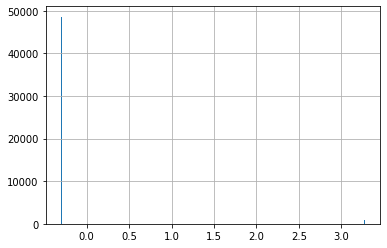

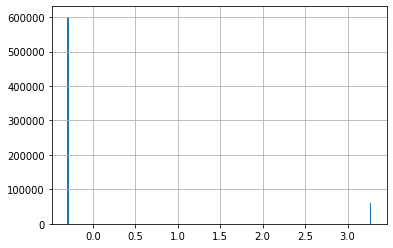

In [28]:
#train["cnn_feature"]=fix_distributed(train["cnn_feature"].to_pandas()).astype("float16")
#test["cnn_feature"]=fix_distributed(test["cnn_feature"].to_pandas()).astype("float16")
test["cnn_feature"].to_pandas().hist(bins=200)
plt.show()
train["cnn_feature"].to_pandas().hist(bins=200)
plt.show()

# Train & Infer XGBoost model

In [29]:
train=train.to_pandas()

In [30]:
# ==============================
# training & inference
# ==============================

cfg.folds = get_groupkfold(train, 'contact', 'game_play', cfg.num_fold)
cfg.folds.to_csv(os.path.join(cfg.EXP_PREDS, 'folds.csv'), index=False)

oof_pred[np.where(cond_dis_train)] = fit_xgboost(cfg, train[feature_cols], train['contact'], 
                                              cfg.xgb_params, add_suffix="_xgb_1st")
np.save('oof_pred.npy',oof_pred)

0    119036
1     13030
Name: contact, dtype: int64

[0]	train-auc:0.84285	eval-auc:0.84449
[100]	train-auc:0.98291	eval-auc:0.96511
[200]	train-auc:0.99376	eval-auc:0.97049
[300]	train-auc:0.99655	eval-auc:0.97142
[400]	train-auc:0.99823	eval-auc:0.97187
[500]	train-auc:0.99908	eval-auc:0.97208
[599]	train-auc:0.99951	eval-auc:0.97194
Performance of the prediction: 0.97194



0    119346
1     12837
Name: contact, dtype: int64

[0]	train-auc:0.84740	eval-auc:0.83648
[100]	train-auc:0.98281	eval-auc:0.96591
[200]	train-auc:0.99386	eval-auc:0.97054
[300]	train-auc:0.99675	eval-auc:0.97153
[400]	train-auc:0.99834	eval-auc:0.97157
[500]	train-auc:0.99916	eval-auc:0.97157
[543]	train-auc:0.99937	eval-auc:0.97154
Performance of the prediction: 0.97154



0    118752
1     13412
Name: contact, dtype: int64

[0]	train-auc:0.84750	eval-auc:0.83414
[100]	train-auc:0.98323	eval-auc:0.96063
[200]	train-auc:0.99389	eval-auc:0.96607
[300]	train-auc:0.99684	eval-auc:0.96713
[400]	train-auc:0.99829	eval-auc:0.96736
[500]	train-auc:0.99912	eval-auc:0.96736
[548]	train-auc:0.99935	eval-auc:0.96724
Performance of the prediction: 0.96724



0    119387
1     12574
Name: contact, dtype: int64

[0]	train-auc:0.84553	eval-auc:0.82740
[100]	train-auc:0.98326	eval-auc:0.96118
[200]	train-auc:0.99392	eval-auc:0.96599
[300]	train-auc:0.99679	eval-auc:0.96664
[400]	train-auc:0.99830	eval-auc:0.96694
[500]	train-auc:0.99912	eval-auc:0.96701
[600]	train-auc:0.99953	eval-auc:0.96708
[700]	train-auc:0.99976	eval-auc:0.96698
[712]	train-auc:0.99977	eval-auc:0.96696
Performance of the prediction: 0.96696



0    119720
1     12459
Name: contact, dtype: int64

[0]	train-auc:0.84681	eval-auc:0.83248
[100]	train-auc:0.98372	eval-auc:0.96109
[200]	train-auc:0.99395	eval-auc:0.96586
[300]	train-auc:0.99678	eval-auc:0.96683
[400]	train-auc:0.99826	eval-auc:0.96684
[478]	train-auc:0.99896	eval-auc:0.96673
Performance of the prediction: 0.96673

All Performance of the prediction: 0.96887


# Submission

In [31]:
# ==============================
# optimize
# ==============================
def func(x_list):
    score = matthews_corrcoef(train_y, oof_pred>x_list[0])
    return -score

x0 = [0.5]
result = minimize(func,x0, method="nelder-mead")
cfg.threshold = result.x[0]
print("score:", round(matthews_corrcoef(train_y, oof_pred>cfg.threshold), 5))
print("threshold", round(cfg.threshold, 5))

score: 0.74532
threshold 0.31855


In [32]:
del train
_ = gc.collect(2)

In [33]:
sub_pred = pred_xgboost(test.loc[cond_dis_test, feature_cols].to_pandas(), cfg.EXP_MODEL, add_suffix="_xgb_1st")

test['contact'] = 0
test.loc[cond_dis_test, 'contact'] = sub_pred
test[['contact_id', 'contact']].to_csv('xgb_output.csv', index=False)

test['contact'] = (test['contact'] > cfg.threshold).astype(int)
test[['contact_id', 'contact']].to_csv('submission.csv', index=False)
display(test[['contact_id', 'contact']].head())

,contact_id,contact
0,58168_003392_0_37084_37211,0
1,58168_003392_0_37084_38556,0
2,58168_003392_0_37084_38567,0
3,58168_003392_0_37084_38590,0
4,58168_003392_0_37084_39947,0
